# Facial Analysis using DeepFace

In [1]:
import itertools
import json
import os
from pprint import pprint
import tempfile
from typing import List, Optional, Tuple

from tqdm import tqdm

import cv2 as cv
import numpy as np
from sklearn import metrics

from deepface import DeepFace

import matplotlib
from matplotlib import pyplot as plt

## Load Via annotations

In [2]:
images_root = '../images/raw'

via_project_path = os.path.join(images_root, 'via_project_13Sep2022_19h41m.json')

In [3]:
with open(via_project_path, 'r') as f:
    via_project = json.load(f)
    
via_images = via_project['_via_image_id_list']
via_metadata = via_project['_via_img_metadata']
print(f'Dataset contains {len(via_images)} 2x2 images')

Dataset contains 27 2x2 images


In [4]:
via_img = via_images[0]
img_metadata = via_metadata[via_img]

img_path = os.path.join(images_root, img_metadata['filename'])
img_regions = img_metadata['regions']
print(f'Image annotations: {img_path}')
pprint(img_metadata)

Image annotations: ../images/raw\vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png
{'file_attributes': {'height': '512', 'width': '512'},
 'filename': 'vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png',
 'regions': [{'region_attributes': {'gender': 'Woman'},
              'shape_attributes': {'height': 175,
                                   'name': 'rect',
                                   'width': 134,
                                   'x': 66,
                                   'y': 21}},
             {'region_attributes': {'gender': 'Man'},
              'shape_attributes': {'height': 124,
                                   'name': 'rect',
                                   'width': 93,
                                   'x': 338,
                                   'y': 43}},
             {'region_attributes': {'gender': 'Woman'},
              'shape_attributes': {'height': 187,
                                   'name': 'rect',
           

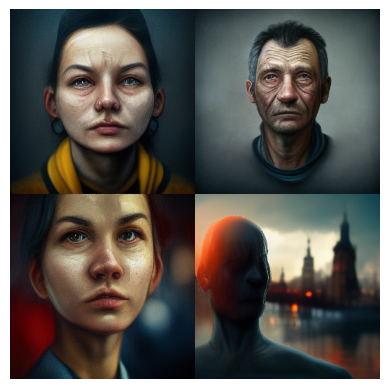

In [5]:
def cv_imshow(image) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
img_2x2 = cv.imread(img_path)
cv_imshow(img_2x2)

In [6]:
def quadrant_bboxes(img_size: Tuple[int, int]) -> List[List[int]]:
    width, height = [d // 2 for d in img_size]
    bboxes = [[x0, y0, x0+width, y0+height] for x0 in [0, width] for y0 in [0, height]]
    return bboxes

def crop_bbox(image: np.ndarray, bbox: np.array) -> np.ndarray:
    x0, y0, x1, y1 = bbox
    return image[y0:y1, x0:x1]

In [7]:
def draw_bbox(
    image: np.ndarray,
    bbox: List[int],
    text: Optional[str] = None,
    color:
    Tuple[int, int, int] = (255,)*3,
    thickness: int = 1,
    fontFace: int = cv.FONT_HERSHEY_SIMPLEX,
    fontScale: float = 0.5
) -> np.ndarray:
    
    cv.rectangle(
        image,
        bbox[:2],
        bbox[2:],
        color=color,
        thickness=thickness
    )
    
    if text:
        (_, h), _ = cv.getTextSize(text, fontFace=fontFace, fontScale=fontScale, thickness=thickness)
        cv.putText(
            image,
            text,
            (bbox[0], bbox[1]+h),
            fontFace=cv.FONT_HERSHEY_SIMPLEX,
            fontScale=fontScale,
            color=color,
            thickness=thickness
    )   
    
    return image

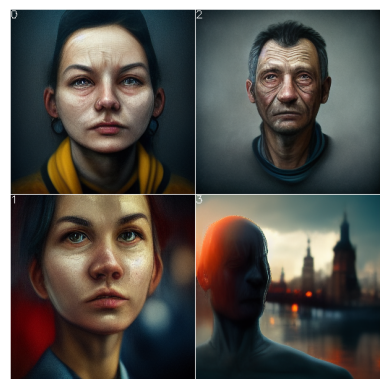

In [8]:
img_2x2 = cv.imread(img_path)

for i, bbox in enumerate(quadrant_bboxes(img_2x2.shape[:2])):
    draw_bbox(img_2x2, bbox, text=f'{i}')

cv_imshow(img_2x2)

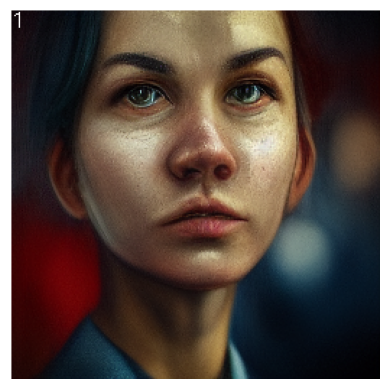

In [9]:
img_sw = crop_bbox(img_2x2, quadrant_bboxes(img_2x2.shape[:2])[1])
cv_imshow(img_sw)

In [10]:
def df_bbox(region) -> List[int]:
    bbox = [
        region['x'],
        region['y'],
        region['x'] + region['w'],
        region['y'] + region['h']
    ]
    return bbox

def df_predictions(analysis: List[int], actions: Tuple[int]) -> dict:
    predictions = {action: analysis[action] for action in actions}
    predictions['bbox'] = df_bbox(analysis['region'])
    return predictions

In [11]:
df_backends = [
    'opencv',
    'ssd',
    'dlib',
    'mtcnn',
    'retinaface',
    'mediapipe'
]

df_actions = [
    'age',
    'gender',
    'race',
    'emotion'
]

def image_predictions(
    image: np.ndarray,
    actions: Tuple[int] = ('age', 'gender', 'race', 'emotion'),
    detector_backend: str = 'mtcnn',
    min_size: int = 20
) -> Optional[dict]:
    
    assert(all(action in df_actions for action in actions))
    assert(detector_backend in df_backends)
    
    predictions = None
    try:
        r = DeepFace.analyze(
            img_path=image,
            actions=actions,
            detector_backend=detector_backend,
            enforce_detection=True,
            prog_bar=False
        )
        if r['region']['w'] >= min_size and r['region']['h'] >= min_size:
            predictions = df_predictions(r, actions)
    except ValueError:
        pass
        
    return predictions

def quadrant_predictions(
    image: np.ndarray,
    **kwargs: dict,
) -> List[Optional[dict]]:
    
    results = []
    for bbox in quadrant_bboxes(image.shape[:2]):
        img_quadrant = crop_bbox(image, bbox)
        predictions = image_predictions(
            img_quadrant,
            **kwargs
        )
        if predictions:
            predictions['bbox'] = [x + y for x, y in zip(predictions['bbox'], bbox[:2]*2)]
        results.append(predictions)
    return results

In [13]:
img_2x2 = cv.imread('2x2.png')
img_sw = crop_bbox(img_2x2, quadrant_bboxes(img_2x2.shape[:2])[1])
predictions = image_predictions(img_sw, detector_backend='mtcnn')
pprint(predictions)

1/1 [==============================] - 0s 27ms/step
{'age': 25,
 'bbox': [33, 0, 201, 191],
 'emotion': {'angry': 5.0065964460372925,
             'disgust': 0.003950842801714316,
             'fear': 1.5365757048130035,
             'happy': 30.47293722629547,
             'neutral': 5.732032284140587,
             'sad': 2.5591636076569557,
             'surprise': 54.688745737075806},
 'gender': {'Man': 24.55480247735977, 'Woman': 75.44519305229187},
 'race': {'asian': 0.31923078931868076,
          'black': 0.01849999971454963,
          'indian': 0.2657572505995631,
          'latino hispanic': 10.199444741010666,
          'middle eastern': 9.139369428157806,
          'white': 80.05769848823547}}


In [14]:
def project_predictions(
    via_project: dict,
    project_root: str,
    actions: Tuple[int] = ('age', 'gender', 'race', 'emotion'),
    detector_backend: str = 'mtcnn'
) -> List[Tuple[str, List[Optional[dict]]]]:
    predictions = []
    for image_id in tqdm(via_project['_via_image_id_list']):
        filename = via_project['_via_img_metadata'][image_id]['filename']
        image = cv.imread(os.path.join(project_root, filename))
        r = quadrant_predictions(image, actions=actions, detector_backend=detector_backend)
        predictions.append({
            'filename': filename,
            'predictions': r
        })
    return predictions

In [15]:
backend = 'mtcnn'
predictions = project_predictions(via_project, '../images/raw', detector_backend=backend)
pprint(f'Predictions for {len(predictions)} images')

  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  4%|███                                                                                | 1/27 [00:06<02:57,  6.83s/it]

1/1 [==============================] - 0s 19ms/step


  7%|██████▏                                                                            | 2/27 [00:14<03:01,  7.27s/it]

1/1 [==============================] - 0s 26ms/step


 11%|█████████▏                                                                         | 3/27 [00:22<03:08,  7.86s/it]

1/1 [==============================] - 0s 24ms/step


 15%|████████████▎                                                                      | 4/27 [00:31<03:11,  8.31s/it]

1/1 [==============================] - 0s 26ms/step


 19%|███████████████▎                                                                   | 5/27 [00:39<02:59,  8.17s/it]

1/1 [==============================] - 0s 24ms/step


 22%|██████████████████▍                                                                | 6/27 [00:47<02:47,  8.00s/it]

1/1 [==============================] - 0s 27ms/step


 26%|█████████████████████▌                                                             | 7/27 [00:55<02:40,  8.03s/it]

1/1 [==============================] - 0s 22ms/step


 30%|████████████████████████▌                                                          | 8/27 [01:01<02:21,  7.47s/it]

1/1 [==============================] - 0s 18ms/step


 33%|███████████████████████████▋                                                       | 9/27 [01:08<02:07,  7.11s/it]

1/1 [==============================] - 0s 19ms/step


 37%|██████████████████████████████▎                                                   | 10/27 [01:14<01:57,  6.90s/it]

1/1 [==============================] - 0s 19ms/step


 41%|█████████████████████████████████▍                                                | 11/27 [01:22<01:55,  7.24s/it]

1/1 [==============================] - 0s 26ms/step


 44%|████████████████████████████████████▍                                             | 12/27 [01:29<01:46,  7.09s/it]

1/1 [==============================] - 0s 20ms/step


 48%|███████████████████████████████████████▍                                          | 13/27 [01:38<01:45,  7.55s/it]

1/1 [==============================] - 0s 21ms/step


 52%|██████████████████████████████████████████▌                                       | 14/27 [01:48<01:49,  8.41s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████████████████████████████████████████████▌                                    | 15/27 [01:58<01:48,  9.02s/it]

1/1 [==============================] - 0s 19ms/step


 59%|████████████████████████████████████████████████▌                                 | 16/27 [02:07<01:39,  9.02s/it]

1/1 [==============================] - 0s 20ms/step


 63%|███████████████████████████████████████████████████▋                              | 17/27 [02:13<01:19,  7.98s/it]

1/1 [==============================] - 0s 25ms/step


 67%|██████████████████████████████████████████████████████▋                           | 18/27 [02:22<01:15,  8.43s/it]

1/1 [==============================] - 0s 32ms/step


 70%|█████████████████████████████████████████████████████████▋                        | 19/27 [02:36<01:19,  9.95s/it]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████████▋                     | 20/27 [02:47<01:12, 10.34s/it]

1/1 [==============================] - 0s 30ms/step


 78%|███████████████████████████████████████████████████████████████▊                  | 21/27 [02:58<01:02, 10.37s/it]

1/1 [==============================] - 0s 32ms/step


 81%|██████████████████████████████████████████████████████████████████▊               | 22/27 [03:07<00:49,  9.94s/it]

1/1 [==============================] - 0s 29ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 23/27 [03:17<00:40, 10.17s/it]

1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████▉         | 24/27 [03:29<00:31, 10.52s/it]

1/1 [==============================] - 0s 40ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 25/27 [03:41<00:22, 11.23s/it]

1/1 [==============================] - 0s 33ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 26/27 [03:53<00:11, 11.28s/it]

1/1 [==============================] - 0s 32ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [04:04<00:00,  9.04s/it]

'Predictions for 27 images'


In [17]:
predictions_path = os.path.join('../images/processed', f'deepface_{backend}.json')

with open(predictions_path, 'w') as fp:
    json.dump(
        predictions,
        fp,
        indent=4,
        sort_keys=True
    )